# KNN Classification

In [1]:
%%html

<link rel="stylesheet" href="theme/custom.css">

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set some Pandas options
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)

# Set some Matplotlib options
matplotlib.rcParams.update({'font.size': 20})

from matplotlib.colors import ListedColormap
from sklearn import feature_selection
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier as KNN

# Store data in a consistent place
skin = pd.read_csv("../../data/skin.tsv", sep="\t", names=['B','G','R','skin'])
# Replace 2 with 0 for standard value of False
skin.skin.replace(2,0,inplace=True)
# Reorder colums for standard color format ar rgb
skin = skin[['R','G','B','skin']]

### Exploratory Data Analysis

In [5]:
print skin.head(2)
print skin.tail(2)
# Check if any data is missing
any([pd.isnull(col) for col in skin])

     R   G   B  skin
0  123  85  74     1
1  122  84  73     1
          R    G    B  skin
245055  112  162  163     0
245056  255  255  255     0


False

/home/io/.tools/anaconda/envs/ds/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


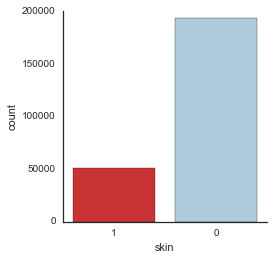

In [6]:
# Visualise data
myui = ["#e31a1c", "#a6cee3"]

sns.set(style="white", palette=sns.color_palette(myui))
sns.factorplot("skin", data=skin, kind="count");

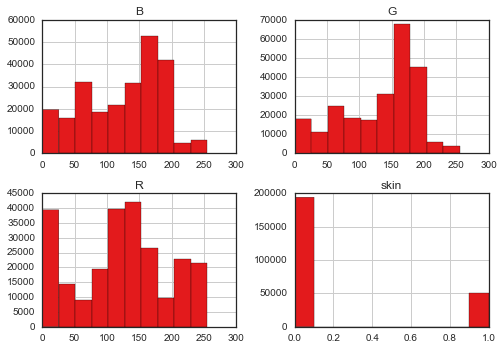

In [7]:
skin.hist();

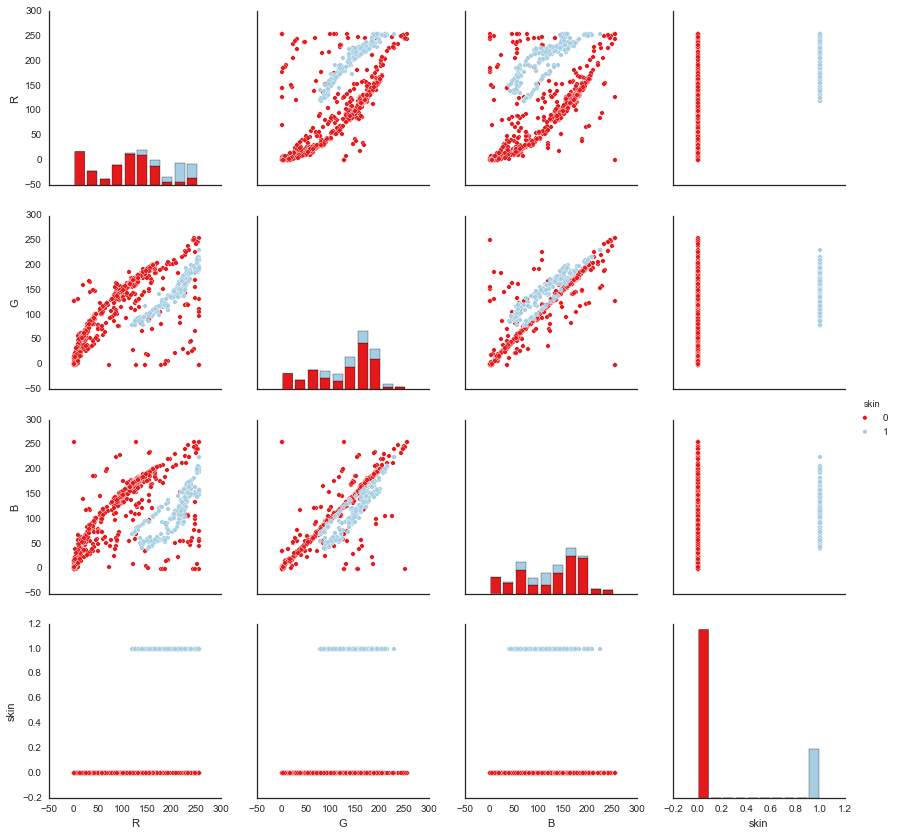

In [18]:
sns.pairplot(skin.sample(1000), hue="skin", size=3);

### Splitting into Training / Test set

We need to balance the classes, because not-skin is overrepresented.

In [57]:
import random
df = skin
feat = 'skin'

n = min(skin[feat].value_counts())
max_class = int(skin[feat].value_counts().idxmax())
max_rows = random.sample(skin[skin[feat] == max_class].index, n)
min_class = int(skin[feat].value_counts().idxmin())
min_rows = skin[skin[feat] == min_class].index
rows = np.r_[min_rows, max_rows]
print n, max_class, len(max_rows), min_class, len(min_rows),len(rows)

50859 0 50859 1 50859 101718


In [58]:
skinx = skin.ix[rows,:]

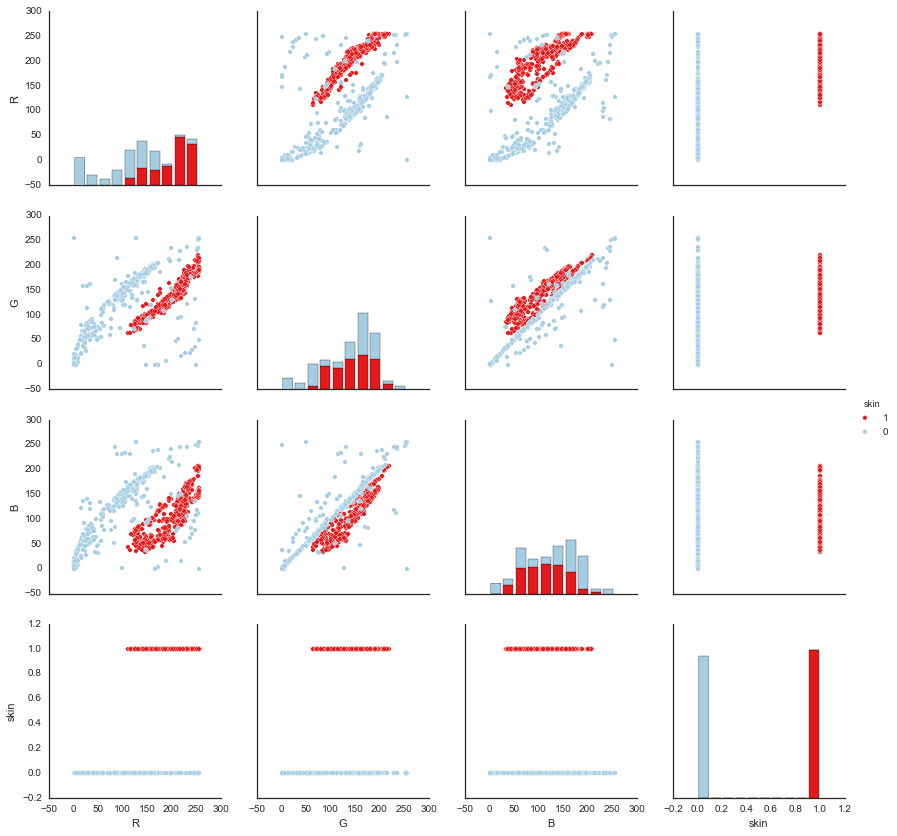

In [59]:
sns.pairplot(skinx.sample(1000), hue="skin", size=3);

In [60]:
X = skinx.ix[:,:-1]
y = skinx.ix[:,-1]

In [61]:
cross_validation.cross_val_score(clf, X, y, cv=5)

array([ 0.97906017,  0.99877114,  0.99857452,  0.99788635,  0.99911513])

In [62]:
k_neighbors = 10
clf = KNN(k_neighbors)
scores = cross_validation.cross_val_score(clf, X, y, cv=5)
print scores, scores.mean()

[ 0.97906017  0.99877114  0.99857452  0.99788635  0.99911513] 0.99468146117


In [65]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.30,
                                        random_state=10)

In [66]:
n_neighbors = range(1,52,2)

In [67]:
# Loop through each neighbors value from 1 to 51 and append
# the scores
scores = []
for n in n_neighbors:
    clf = KNN(n)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

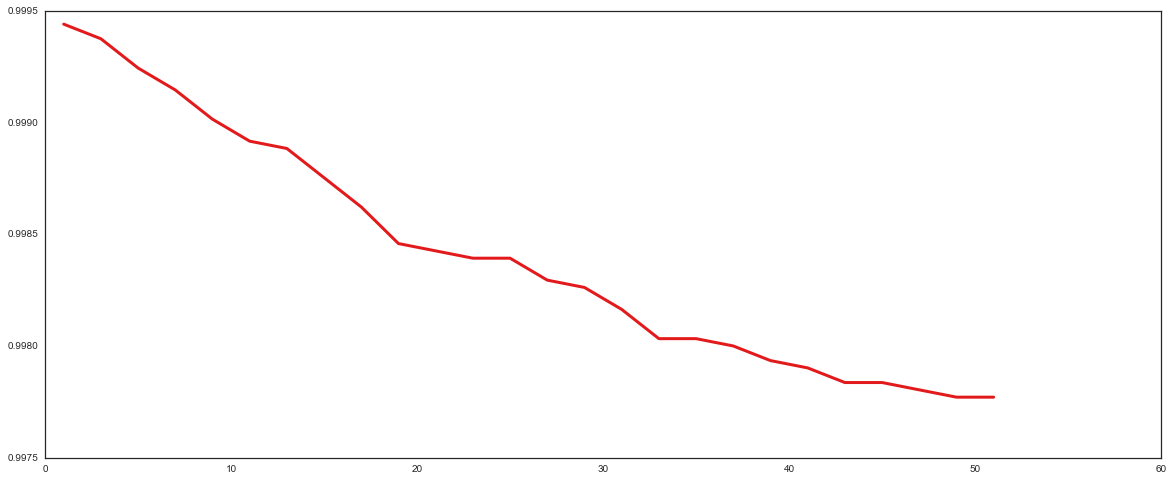

In [68]:
plt.figure(figsize=(20,8))
plt.plot(n_neighbors, scores, linewidth=3.0);

Let's see how stable our optimal value of K is...

Simulate it a 1000 times to get the most reliable value of K

In [1]:
# Or by using the built-in method from SciKit-Learn
from collections import defaultdict
from sklearn.cross_validation import train_test_split

# Loop through each neighbors value from 1 to 51 and append
# the scores
n_neighbors = range(1,12,2)
scores = defaultdict(list)
for _ in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    for n in n_neighbors:
        clf = KNN(n)
        clf.fit(X_train, y_train)
        scores[n].append(clf.score(X_test, y_test))

scoresm = [np.mean(scores[k]) for k in scores]

NameError: name 'X' is not defined

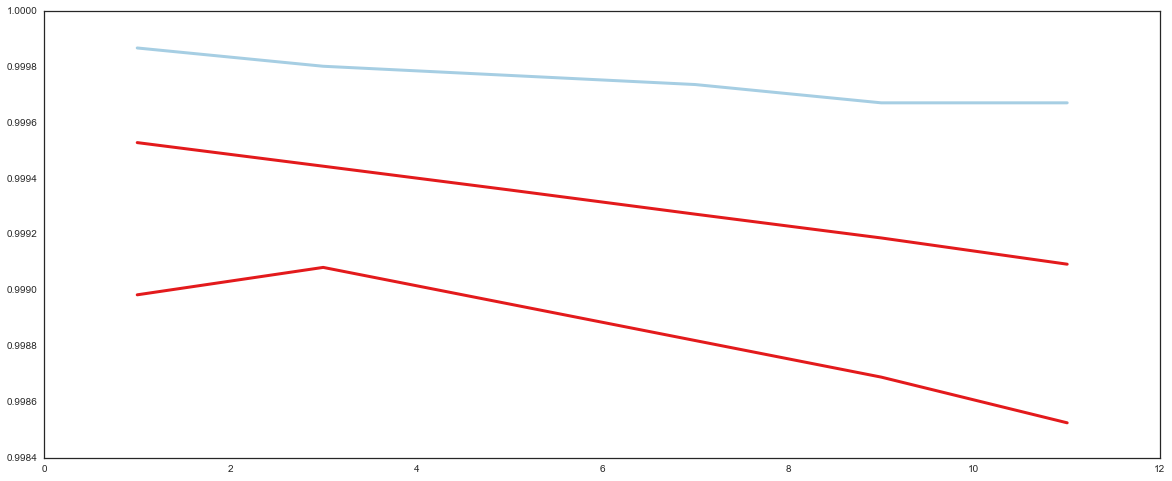

In [18]:
scoresmax = [np.max(scores[k]) for k in scores]
scoresmin = [np.min(scores[k]) for k in scores]
plt.figure(figsize=(20,8))
# plt.plot(n_neighbors, scores, linewidth=3.0);
plt.plot(n_neighbors, scoresmin, linewidth=3.0)
plt.plot(n_neighbors, scoresmax, linewidth=3.0)
plt.plot(n_neighbors, scoresm, linewidth=3.0);

In [70]:
print 'Best value for K is', np.argmax(scores) * 2 + 1

Best value for K is 1


### Simplifying the Model

To showcase our whole model's performance, we can plot our algorithm against the two most significant features available in this data set.

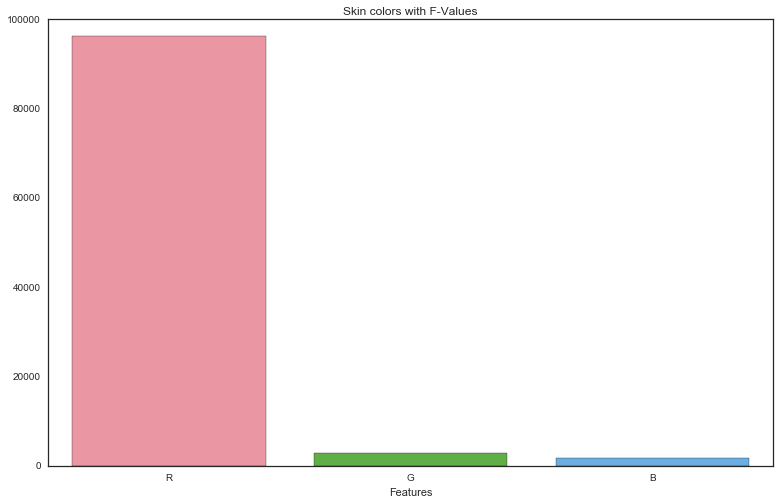

In [71]:
# Let's figure out what our most powerful features are.

F = feature_selection.f_classif(X, y)[0]
title = 'Skin colors with F-Values'

plt.figure(figsize=(13, 8))
ax = sns.barplot(x=skin.columns[:-1],y=F)
ax.set_title(title)
ax.set(xlabel="Features");

In [72]:
X.values

array([[123,  85,  74],
       [122,  84,  73],
       [121,  83,  72],
       ..., 
       [ 25,  60,  56],
       [114, 124, 125],
       [  9,  25,  24]])

In [73]:
# Non-sensical test
from scipy.stats import f_oneway
f_oneway(*X.values)

# f_oneway expect an array as: feature, sample a, sample b, sample c, etc

F_onewayResult(statistic=4.6458407928154912, pvalue=0.0)

In [74]:
df_skin = X.copy()
df_skin['skin'] = y
df_skin.head()

,R,G,B,skin
0,123,85,74,1
1,122,84,73,1
2,121,83,72,1
3,119,81,70,1
4,119,81,70,1


In [75]:
# F-Statistic with their accompanying P-values
for col in df_skin.columns[:-1]:
    f_stat = f_oneway(*[g[col] for k, g in df_skin.groupby('skin')])
    print "{:<14} {:<6.0f} {:.2e}".format(col, f_stat.statistic, f_stat.pvalue)

R              96308  0.00e+00
G              2947   0.00e+00
B              1665   0.00e+00


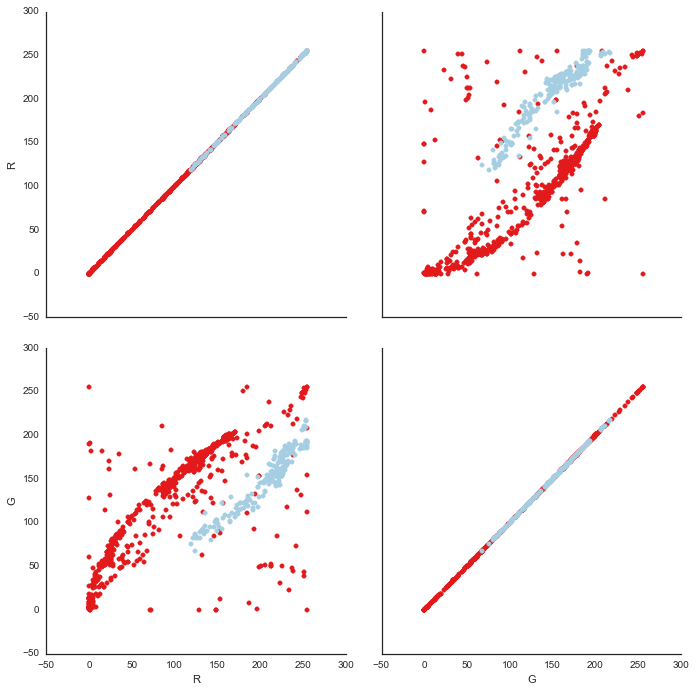

In [76]:
g = sns.PairGrid(skin.sample(1000), vars=["R", "G"],
                 hue="skin", aspect=1, size=5)
g.map(plt.scatter);

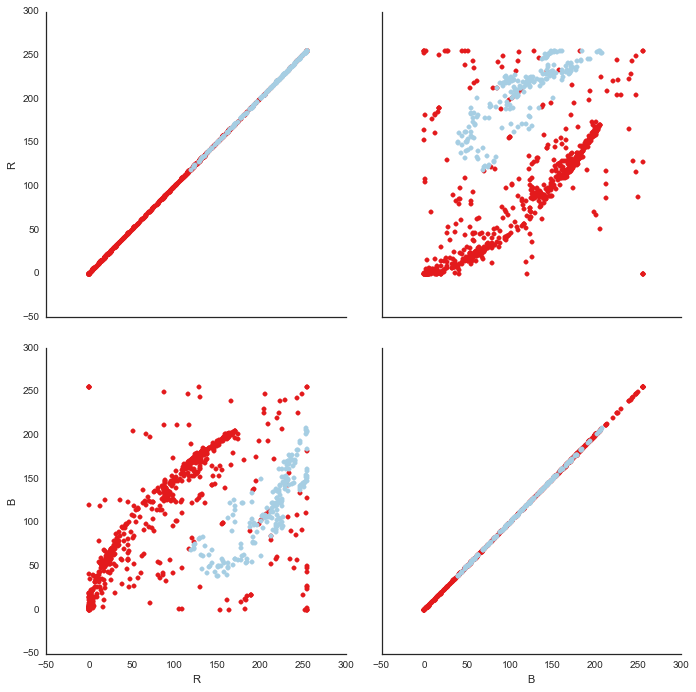

In [77]:
g = sns.PairGrid(skin.sample(1000), vars=["R", "B"],
                 hue="skin", aspect=1, size=5)
g.map(plt.scatter);

### Visualising the Decision Boundaries

In [79]:
h = 1  # step size in the mesh

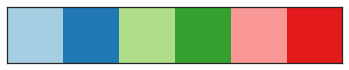

In [80]:
# Create color maps
col_map = sns.color_palette("Paired")
sns.palplot(col_map)
cmap_light = ListedColormap(['#A6CEE3', '#AFDD8A', '#FA9897'])
cmap_bold = ListedColormap(['#2078B4', '#35A12E', '#E31A1C'])

In [81]:
X_ = X.ix[:, 0:2].values

In [82]:
X_

array([[123,  85],
       [122,  84],
       [121,  83],
       ..., 
       [ 25,  60],
       [114, 124],
       [  9,  25]])

In [83]:
y

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
         ..
120701    0
70003     0
112207    0
160291    0
63418     0
52129     0
130131    0
211104    0
63636     0
120319    0
Name: skin, dtype: int64

In [84]:
clf = KNN(10, weights='uniform')
clf.fit(X_, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [90]:
X_

array([[123,  85],
       [122,  84],
       [121,  83],
       ..., 
       [ 25,  60],
       [114, 124],
       [  9,  25]])

In [85]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]*[y_min, y_max].
x_min, x_max = X_[:, 0].min() - 1, X_[:, 0].max() + 1
y_min, y_max = X_[:, 1].min() - 1, X_[:, 1].max() + 1

In [86]:
print x_min, x_max, y_min, y_max

-1 256 -1 256


In [87]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [88]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)

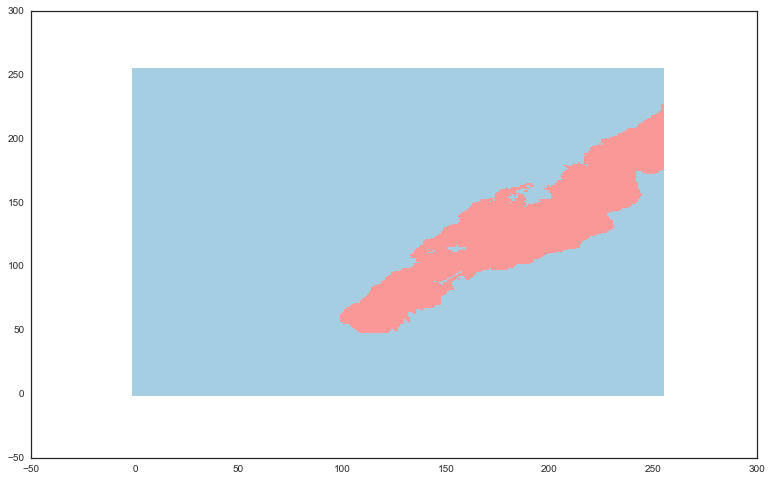

In [89]:
# from matplotlib.pyplot import pcolormesh
plt.figure(figsize=(13,8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

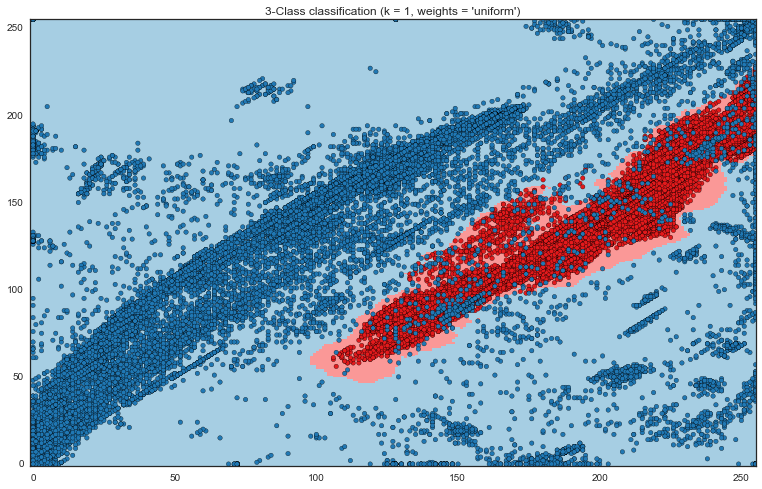

In [38]:
# Plot also the training points
plt.figure(figsize=(13,8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_[:, 0], X_[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
         % (1, 'uniform'));

#### Parallel Coordinates

In [39]:
from sklearn import datasets, metrics, tree, cross_validation
from matplotlib import pyplot as plt

clf = tree.DecisionTreeClassifier()
y_pred = clf.fit(X, y).predict(X)

print "Number of mislabeled points : %d" % (y != y_pred).sum()
print "Score: %f" % (clf.fit(X, y).score(X, y))

Number of mislabeled points : 2
Score: 0.999980


In [53]:
metrics.confusion_matrix(y, clf.predict(X))

array([[50857,     2],
       [    0, 50859]])

In [59]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

n_samples, n_features = X.shape

p = range(n_samples)  # Shuffle samples
print n_samples, n_features
random.seed(0)
random.shuffle(p)

# X, y = X[p], y[p]
half = int(n_samples / 2)

# Add noisy features
np.random.seed(0)
X = np.c_[X, np.random.randn(n_samples, 200 * n_features)]

# Run classifier
classifier = svm.SVC(kernel='linear', probability=True, random_state=0)
# probas_ = classifier.fit(X[:half], y[:half]).predict_proba(X[half:])

# # Compute Precision-Recall and plot curve
# precision, recall, thresholds = precision_recall_curve(y[half:], probas_[:, 1])
# area = auc(recall, precision)
# print("Area Under Curve: %0.2f" % area)

pl.clf()
# pl.plot(recall, precision, label='Precision-Recall curve')
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.0])
pl.title('Precision-Recall example: AUC=%0.2f' % area)
pl.legend(loc="lower left")
pl.show()

101718 603


MemoryError: 

In [57]:
p

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
